In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import os
import numpy as np
import pandas as pd
from abcd.local.paths import core_path, output_path
from abcd.data.read_data import get_subjects_events, add_event_vars
from abcd.plotting.seaborn.scatter import plot_jointplot

In [3]:
# Fetch subjects and events
subjects_df, events_df = get_subjects_events()

In [4]:
# Add mental health outcomes
MH_SCORES = {"cbcl_scr_syn_anxdep_t": "Anxious/Dep.",
             "cbcl_scr_syn_withdep_t": "Depression",
             "cbcl_scr_syn_somatic_t": "Somatic",
             "cbcl_scr_syn_social_t": "Social",
             "cbcl_scr_syn_attention_t": "Attention",
             "cbcl_scr_syn_rulebreak_t": "Rule-breaking",
             "cbcl_scr_syn_aggressive_t": "Aggressive",
             "cbcl_scr_syn_internal_t": "Internalizing",
             "cbcl_scr_syn_external_t": "Externalizing"}    

mental_health_file = os.path.join(core_path, "mental-health", "mh_p_cbcl.csv")
mh_events_df = add_event_vars(events_df, mental_health_file, vars=list(MH_SCORES.keys()))
print("From those, there are {} events with mental health scores".format(len(mh_events_df)))
# Remove missing values
mh_events_df = mh_events_df.dropna()
print("After removing missing values, the df has {} events".format(len(mh_events_df)))

From those, there are 19573 events with mental health scores
After removing missing values, the df has 18370 events


c:\users\camgonza\desktop\abcd5\abcd\utils\io.py:24: DtypeWarning: Columns (124,128,132,136,140,144,148,152,156,160,164,168,172,176,180,184,188,192,196,200) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=sep)


In [5]:
# Plot distribution of variables
import pygal
from abcd.plotting.pygal.rendering import display_html

plot = pygal.Box()
plot.title = 'Child behavior checklist CBCL syndrome scales'
for var_id, var_name in MH_SCORES.items():
    plot.add(var_name, list(mh_events_df[var_id]))
display_html(plot)

In [6]:
# For each score, how many visity do we have with over 65?
for mh_key, mh_val in MH_SCORES.items():
    new_df = mh_events_df.loc[(mh_events_df[mh_key] >= 65)]
    print('{} visits with {} >= 65'.format(len(new_df), mh_val))

1299 visits with Anxious/Dep. >= 65
1269 visits with Depression >= 65
1397 visits with Somatic >= 65
685 visits with Social >= 65
1141 visits with Attention >= 65
571 visits with Rule-breaking >= 65
835 visits with Aggressive >= 65
1535 visits with Internalizing >= 65
734 visits with Externalizing >= 65


In [20]:
# From those, how was the trajectory of each subject?
from tqdm import tqdm
# Encode the 2nd and 4th year follow-ups with the baseline
trajectory_df = {'Baseline '+mh_score: [] for mh_score in MH_SCORES.values()}
trajectory_df.update({mh_score: [] for mh_score in MH_SCORES.values()})
trajectory_df['Subject'], trajectory_df['Visit'] = [], []
all_subjects = set(mh_events_df['src_subject_id'])
for subject_id in tqdm(all_subjects):
    baseline = mh_events_df.loc[((mh_events_df['eventname'] == 'baseline_year_1_arm_1') & (mh_events_df['src_subject_id'] == subject_id))]
    if len(baseline) > 0:  # Only include subjects with baseline imaging
        second_year = mh_events_df.loc[((mh_events_df['eventname'] == '2_year_follow_up_y_arm_1') & (mh_events_df['src_subject_id'] == subject_id))]
        if len(second_year) > 0:
            trajectory_df['Subject'].append(subject_id)
            trajectory_df['Visit'].append('2nd year')
            for var_id, var_name in MH_SCORES.items():
                trajectory_df['Baseline ' + var_name].append(baseline[var_id].values[0])
                trajectory_df[var_name].append(second_year[var_id].values[0])
        forth_year = mh_events_df.loc[((mh_events_df['eventname'] == '4_year_follow_up_y_arm_1') & (mh_events_df['src_subject_id'] == subject_id))]
        if len(forth_year) > 0:
            trajectory_df['Subject'].append(subject_id)
            trajectory_df['Visit'].append('4th year')
            for var_id, var_name in MH_SCORES.items():
                trajectory_df['Baseline ' + var_name].append(baseline[var_id].values[0])
                trajectory_df[var_name].append(forth_year[var_id].values[0])
#trajectory_df = pd.DataFrame(trajectory_df)

100%|██████████| 9821/9821 [01:15<00:00, 129.31it/s]


In [21]:
trajectory_df = pd.DataFrame(trajectory_df)

In [22]:
trajectory_df

,Baseline Anxious/Dep.,Baseline Depression,Baseline Somatic,Baseline Social,Baseline Attention,Baseline Rule-breaking,Baseline Aggressive,Baseline Internalizing,Baseline Externalizing,Anxious/Dep.,Depression,Somatic,Social,Attention,Rule-breaking,Aggressive,Internalizing,Externalizing,Subject,Visit
0,50.0,50.0,53.0,51.0,50.0,51.0,50.0,45.0,40.0,59.0,54.0,68.0,50.0,53.0,50.0,50.0,65.0,44.0,NDAR_INV0CZBUV4C,2nd year
1,53.0,58.0,53.0,56.0,51.0,53.0,52.0,54.0,51.0,50.0,50.0,50.0,54.0,51.0,50.0,57.0,40.0,53.0,NDAR_INVYKWMEWGG,2nd year
2,51.0,52.0,50.0,50.0,52.0,50.0,50.0,46.0,34.0,50.0,50.0,53.0,50.0,51.0,50.0,50.0,43.0,34.0,NDAR_INVE3MEFJL5,2nd year
3,51.0,52.0,50.0,50.0,52.0,50.0,50.0,46.0,34.0,50.0,57.0,50.0,50.0,54.0,50.0,50.0,48.0,34.0,NDAR_INVE3MEFJL5,4th year
4,52.0,52.0,57.0,52.0,62.0,59.0,57.0,52.0,58.0,51.0,56.0,68.0,51.0,59.0,63.0,51.0,59.0,54.0,NDAR_INV723AA4WA,2nd year
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8433,50.0,50.0,50.0,52.0,55.0,50.0,50.0,39.0,44.0,50.0,51.0,50.0,54.0,56.0,54.0,52.0,43.0,52.0,NDAR_INVM00MPW0G,4th year
8434,66.0,79.0,67.0,62.0,67.0,53.0,59.0,72.0,58.0,78.0,75.0,74.0,58.0,65.0,50.0,57.0,77.0,53.0,NDAR_INV6ETG8KHZ,2nd year
8435,66.0,79.0,67.0,62.0,67.0,53.0,59.0,72.0,58.0,63.0,68.0,70.0,58.0,62.0,51.0,55.0,69.0,53.0,NDAR_INV6ETG8KHZ,4th year
8436,51.0,50.0,57.0,51.0,55.0,50.0,54.0,48.0,51.0,50.0,50.0,57.0,50.0,51.0,50.0,52.0,46.0,49.0,NDAR_INVVPFWLP9R,2nd year


<module 'matplotlib.pyplot' from 'c:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 2000x2000 with 0 Axes>

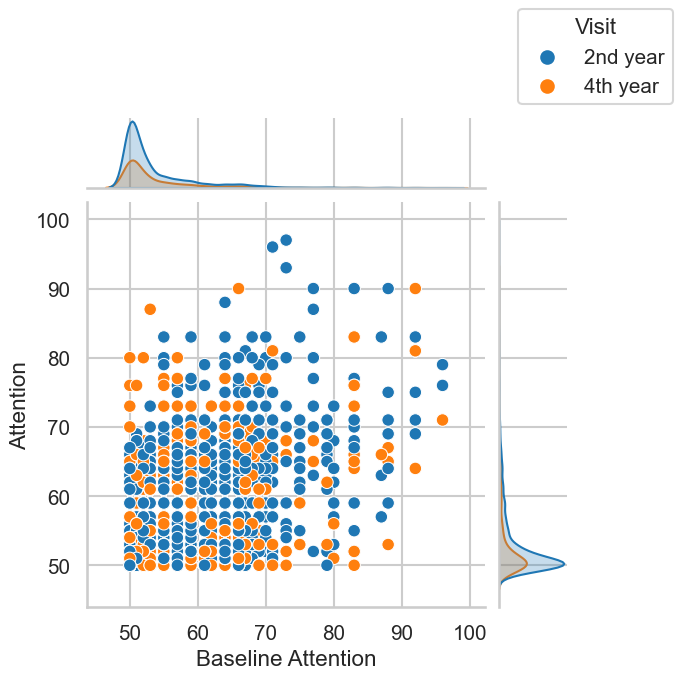

In [40]:
mh_outcome = "Attention"

plot_jointplot(trajectory_df, x_col='Baseline '+mh_outcome, y_col=mh_outcome, hue_col='Visit', title=mh_outcome + ' development', figsize=(20, 20))

In [ ]:
# For each score, how many visity do we have with over 65?
for mh_key, mh_val in MH_SCORES.items():
    new_df = mh_events_df.loc[(mh_events_df[mh_key] >= 65)]
    print('{} visits with {} >= 65'.format(len(new_df), mh_val))